In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tcn', '/content/drive/My Drive/Fax/Master Theses/keras-tcn-master/tcn/tcn.py').load_module()

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from sklearn import preprocessing

import os
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.models import Sequential,load_model, model_from_json

from tcn import TCN

In [0]:
# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/output-tcn-5-2-1'
model_path = output_path+'/model.h5'

data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'

  

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:

#MAXLIFE = 120
MAXLIFE = 125
def kink_RUL(cycle_list, max_cycle):
    '''
    Piecewise linear function with zero gradient and unit gradient

            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_point = max_cycle - MAXLIFE
    if knee_point <= 0:
      knee_point = 1
      
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    return kink_RUL


def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)


def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD001, output a list
    '''
    rul = []
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
        return rul
    else:
        rul = []
        for _id in set(FD00X[id]):
            # print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul


In [0]:

rul=[]

for id in train_df['id'].unique():
  rul.extend(compute_rul_of_one_id (train_df[train_df['id']== id]))

In [8]:
#train_df[train_df['id']==1]
train_df['RUL'].max()

KeyError: ignored

In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
#rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
#rul.columns = ['id', 'max']
#train_df = train_df.merge(rul, on=['id'], how='left')
#train_df['RUL'] = train_df['max'] - train_df['cycle']
#train_df.drop('max', axis=1, inplace=True)
train_df['RUL']= rul

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [10]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [11]:
# pick a large window size of 50 cycles
sequence_length = 120

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
  
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        #print(data_matrix[start:stop, :].shape)
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
#val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
#print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
  
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(8631, 120, 25)


(8631, 1)

In [0]:

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
##output tcn-5
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


i = Input(shape=(sequence_length, nb_features))

m = TCN(nb_filters=12,dropout_rate = 0.2 ,return_sequences=True)(i)
m = TCN(nb_filters=6,dropout_rate = 0.2 ,return_sequences=False)(m)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])
model.summary()

model.compile('adam', 'mae')
model.compile(loss=root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])

# history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
#           callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
#                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#           )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 25)]         0         
_________________________________________________________________
tcn (TCN)                    (None, 120, 12)           4692      
_________________________________________________________________
tcn_1 (TCN)                  (None, 6)                 1224      
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 5,923
Trainable params: 5,923
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


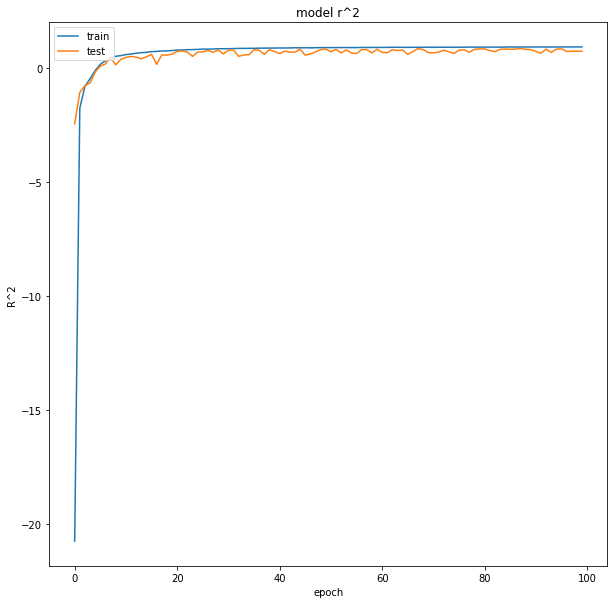

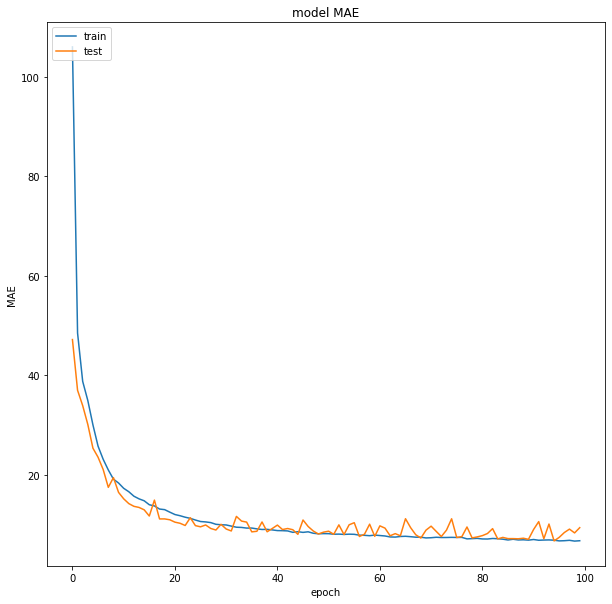

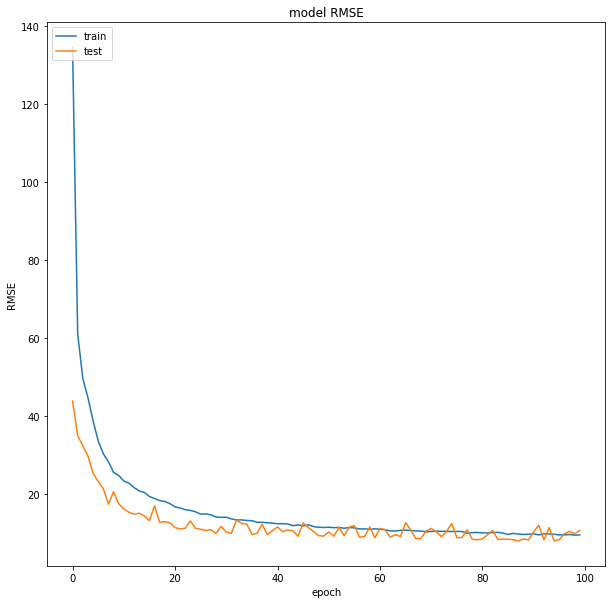

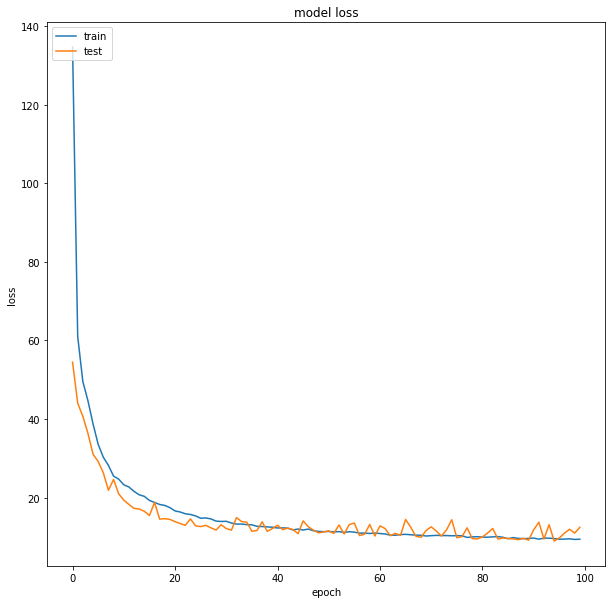

8631/8631 [==============================] - 5s 576us/sample - loss: 11.1044 - mae: 8.7034 - r2_keras: 0.8713 - root_mean_squared_error: 11.0016

MAE: 8.70339584350586

R^2: 0.8713288903236389

RMSE: 11.00156307220459
8631/8631 [==============================] - 6s 643us/sample


In [0]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")


# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
print('\nRMSE: {}'.format(scores[3]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


seq_array_test_last
(63, 120, 25)
(63, 1)
2/2 - 0s - loss: 10.3024 - mean_absolute_error: 6.8882 - r2_keras: 0.9242 - root_mean_squared_error: 10.2963

MAE: 6.88822603225708

R^2: 0.9241577386856079

RMSE: 10.296293258666992


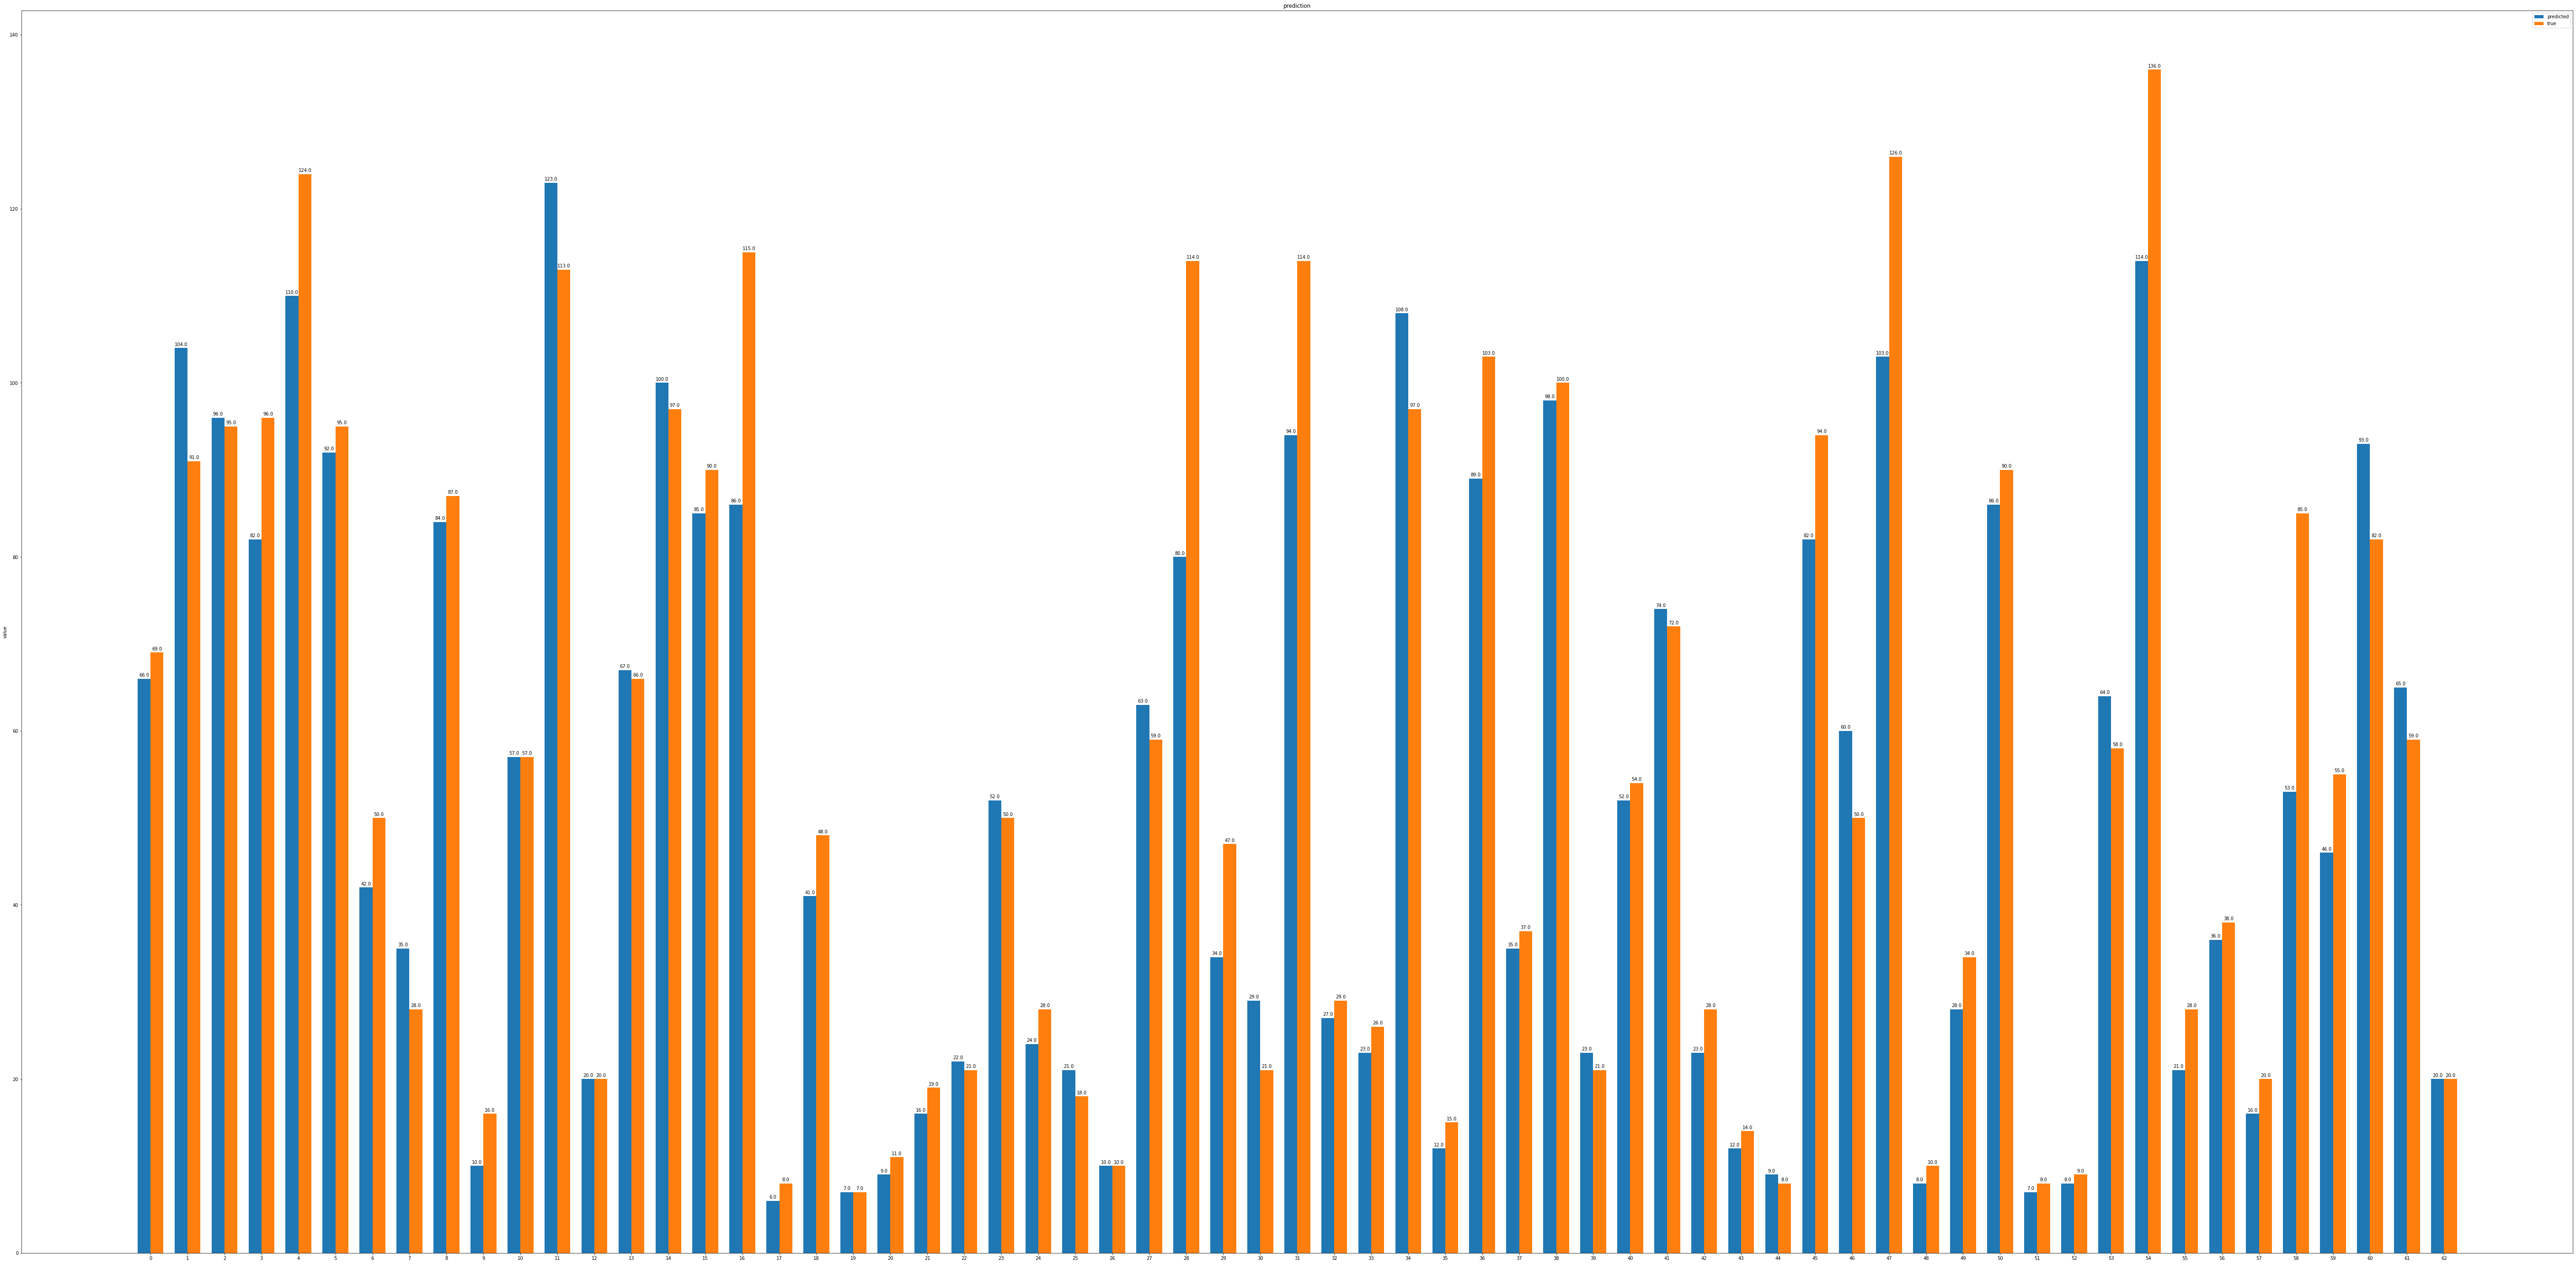

In [14]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):

    # restore weights
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error': root_mean_squared_error,'TCN': TCN})

    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    print('\nRMSE: {}'.format(scores_test[3]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)


    test_set_t = pd.DataFrame(label_array_test_last)
    test_set_t.to_csv(output_path+'/submit_test_t.csv', index = None)

    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path+"/model_verify_bar.png")

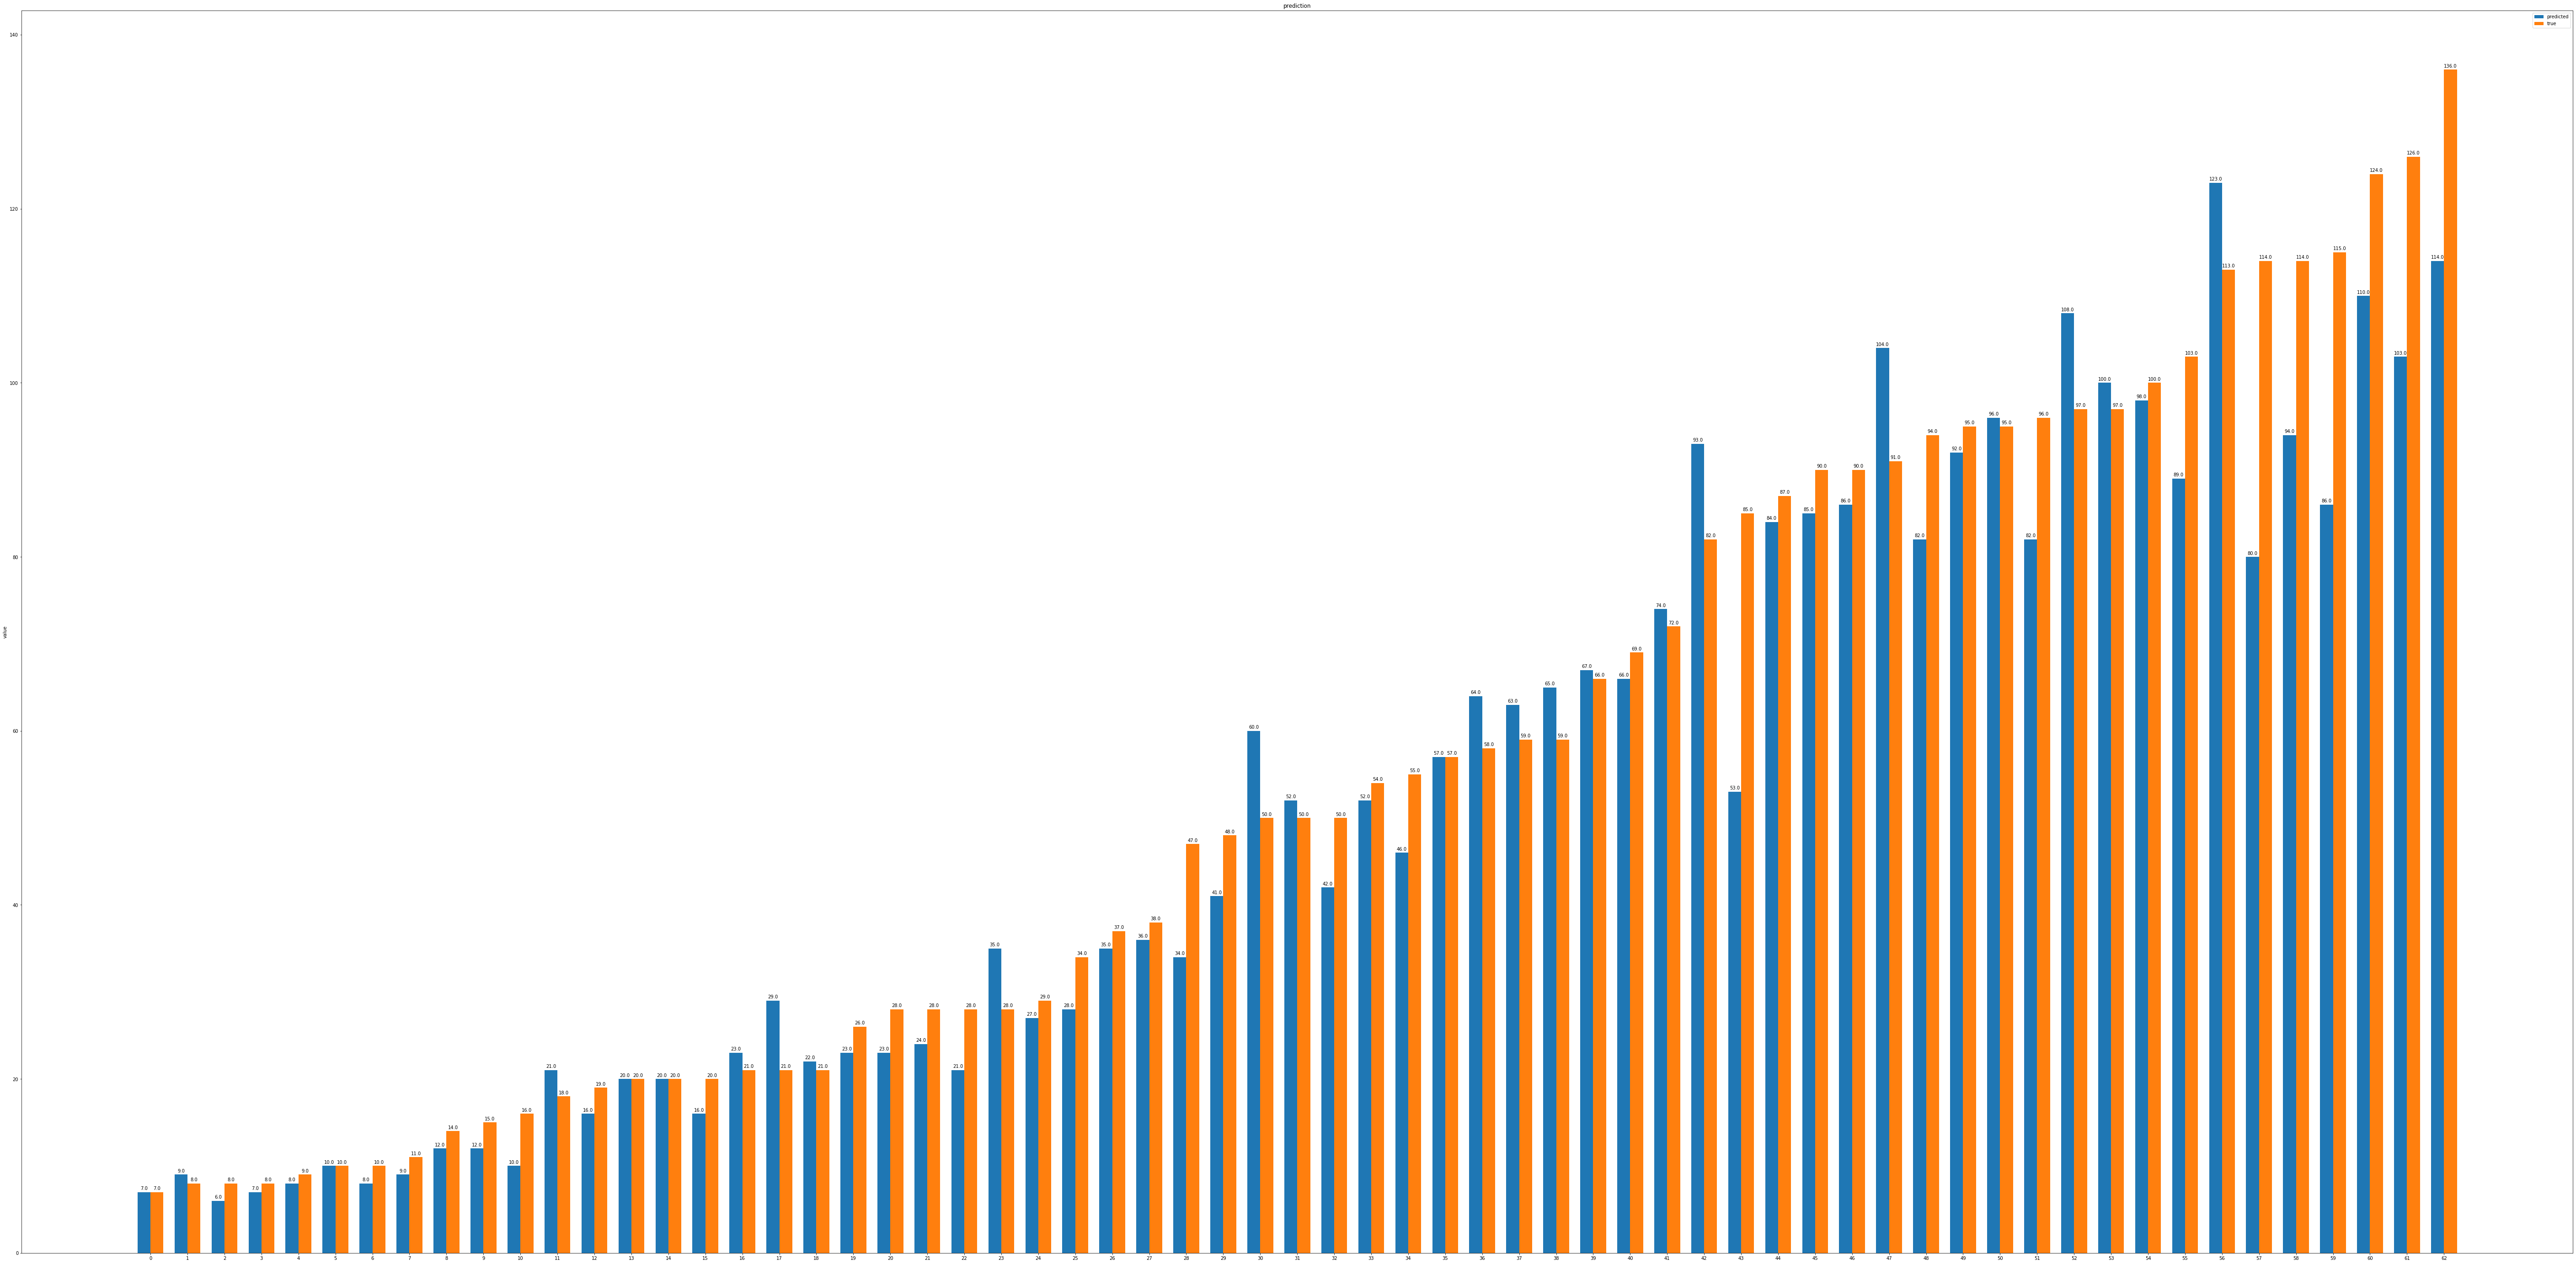

In [0]:

result = pd.DataFrame( columns = ['pred', 'true']) 
result['pred'] = y_pred_test.flatten().round()
result['true'] = y_true_test.flatten()
result.sort_values(by='true', inplace=True)
# Plot in blue color the predicted data and in orange color the
# actual data to verify visually the accuracy of the model.
    
x = np.arange(len(y_pred_test))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(100, 50))
rects1 = ax.bar(x - width/2,result['pred'], width, label='predicted')
rects2 = ax.bar(x + width/2,result['true'], width, label='true')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('prediction')
ax.set_xticks(x)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
fig.savefig(output_path+"/model_verify_bar.png")